In [9]:
import numpy as np
import matplotlib.pyplot as plt
filepath = "mistral_output/"
few_shot =0
fairness = 0.5

fairprompt = False

In [10]:
r_path = f"{filepath}true_race_{few_shot}_{fairness}_{fairprompt}.npy"
l_path = f"{filepath}true_label_{few_shot}_{fairness}_{fairprompt}.npy"
x_path = f"{filepath}outputs_{few_shot}_{fairness}_{fairprompt}.npy"
x_0_path = f"{filepath}output_prob_0_{few_shot}_{fairness}_{fairprompt}.npy"
x_1_path = f"{filepath}output_prob_1_{few_shot}_{fairness}_{fairprompt}.npy"

R = np.load(r_path)
L = np.load(l_path)
X = [[y for y in x] for x in np.load(x_path)]
X = (np.array(X)==" 1").astype(int)
X_0 = np.load(x_0_path)
X_1 = np.load(x_1_path)

In [11]:
def eod(X_0, X_1, L):
    return max(abs((X_0[L==0,0]).sum() / len(X[L==0,0]) -  (X_0[L==0,1]).sum() / len(X[L==0,1])),abs((X_1[L==1,0]).sum() / len(X[L==1,0]) - (X_1[L==1,1]).sum() / len(X[L==1,1])))
def dpd(X_0, X_1):
    return max(abs((X_0[:,0]).sum() / len(X) -  (X_0[:,1]).sum() / len(X)),abs((X_1[:,0]).sum() / len(X[:,0]) - (X_1[:,1]).sum() / len(X[:,1])))

def f1_score(y_true, y_pred):
    tp = (y_true * y_pred).sum()
    fp = ((1-y_true) * y_pred).sum()
    fn = (y_true * (1-y_pred)).sum()
    return tp / (tp + 0.5 * (fp + fn))
def accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

Total Accuracy is  63.0
EOD is  0.18268625126328575
DPD is  0.14188087463378907
The F1 score of predicting in race Male is 0.845360824742268, accuracy is 0.7368421052631579
Total number of people with Male with >50K income:  0.7719298245614035
The F1 score of predicting in race Female is 0.4444444444444444, accuracy is 0.5348837209302325
Total number of people with Female with >50K income:  0.3023255813953488


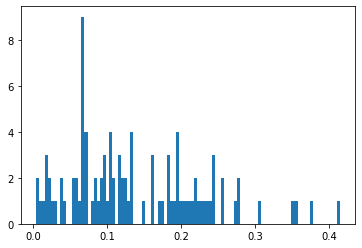

In [12]:
print("Total Accuracy is ", accuracy(L, X[:,1])*100)
print("EOD is ", eod(X_0, X_1, L))
print("DPD is ", dpd(X_0, X_1))
races = {"Male": 0, "Female": 1}
inverce_race = ["Male", "Female"]
R_index = np.array([races[r] for r in R])
for i in range(2):
    print(f"The F1 score of predicting in race {inverce_race[i]} is {f1_score(X[R_index==i][:,i], L[R_index==i])}, accuracy is {accuracy(X[R_index==i][:,i], L[R_index==i])}")
    print(f"Total number of people with {inverce_race[i]} with >50K income:  {L[R_index==i].sum()/len(L[R_index==i])}")
    
plt.hist(np.abs(X_1[:,0] - X_1[:,1]),bins=100)
plt.savefig(f"results/hist_{few_shot}_{fairness}.png")

In [7]:
from dataset import AdultDataset
from tqdm import tqdm
data = AdultDataset(number_of_samples=200,few_shot=16, fairness=None,fairprompt=False)

import numpy as np
l =[]
for d in tqdm(range(len(data))):
    d  = data[d]
    c,tc,p,tp = 0,0,0,0
    for y,s in zip([int(x[-1]) for x  in d[0][0].split("\n") if "label" in x and x[-1] in ["0", "1"]],["Male" in x for x  in d[0][0].split("\n") if ("Male" in x) or ("Female" in x)][:-1]):
        if y == 1 and s:
            c += 1
        if y==1 and not s:
            p += 1
        if s:
            tc +=1
        else:
            tp +=1
    l.append(((c+0.000001)/(tc+0.000001), (p+0.000001)/(tp+0.000001)))

L = np.array(l)
(L[:,0] - L[:,1]).mean()

ModuleNotFoundError: No module named 'ucimlrepo'

In [13]:
from dataset import AdultDataset

In [14]:
data = AdultDataset(number_of_samples=1000,few_shot=16, fairness=None, fairprompt=True)

In [47]:
idx =3
for x in data[idx][0][0].split("\n"):
    print(x)

Predict whether the annual income of the person is greater than $50k
Text: A person in 1996 has the following attributes: age 23, workclass Private, education Some-college, number of years of education 10, occupation Sales, race Black, sex Female, capital gain 0, capital loss 0, hours per week 14, native country United-States
label: 0
Text: A person in 1996 has the following attributes: age 24, workclass Private, education HS-grad, number of years of education 9, occupation Craft-repair, race White, sex Male, capital gain 0, capital loss 0, hours per week 50, native country United-States
label: 0
Text: A person in 1996 has the following attributes: age 50, workclass Private, education Some-college, number of years of education 10, occupation Sales, race White, sex Male, capital gain 0, capital loss 0, hours per week 45, native country United-States
label: 1
Text: A person in 1996 has the following attributes: age 28, workclass Private, education Some-college, number of years of educati

In [512]:
with torch.no_grad():
    logits =torch.rand(2,5)*5
logits = logits.requires_grad_(True)

E = nn.Embedding(5,3)

In [521]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from matplotlib import pyplot as plt
from torch.overrides import has_torch_function_unary, handle_torch_function
import numpy as np

torch.manual_seed(0)
np.random.seed(0)



class GumbelSoftmax(torch.autograd.Function):

    @staticmethod
    def forward(ctx, input):
        L, N = input.shape
        with torch.enable_grad():
            softmaxed = F.gumbel_softmax(input, dim = 1)
        output    = torch.argmax(softmaxed, dim = 1)
        ctx.save_for_backward(input, softmaxed)
        return output, E(output)

    @staticmethod
    def backward(ctx, temp,grad_output):
        input, softmaxed = ctx.saved_tensors
        grad_input = torch.autograd.grad(softmaxed, input, grad_outputs=torch.mm(grad_output,E.weight.T))
        return grad_input



logits.grad = None
out,loss= GumbelSoftmax.apply(logits)

u = loss.sum()

u.backward()
logits.grad,logits


(tensor([[-0.0227,  0.0018,  0.1438, -0.0087, -0.1142],
         [-0.0422,  0.0988,  0.0044, -0.0294, -0.0316]]),
 tensor([[3.8411, 0.4424, 0.6602, 1.5371, 3.1704],
         [2.4505, 4.4822, 2.2781, 3.1615, 1.7445]], requires_grad=True))

In [523]:
torch.manual_seed(0)
np.random.seed(0)

logits = logits.clone().detach().requires_grad_(True)
logits.grad = None  
loss = F.gumbel_softmax(logits,dim=1,tau=1,hard=True)
u = (loss @ E.weight).sum()

u.backward()
logits.grad,logits


(tensor([[-0.0227,  0.0018,  0.1438, -0.0087, -0.1142],
         [-0.0422,  0.0988,  0.0044, -0.0294, -0.0316]]),
 tensor([[3.8411, 0.4424, 0.6602, 1.5371, 3.1704],
         [2.4505, 4.4822, 2.2781, 3.1615, 1.7445]], requires_grad=True))

In [519]:
lr = 0.01
E = nn.Embedding(5,2)
W = nn.Linear(2,1, bias=False)
with torch.no_grad():
    ans= W(E(torch.tensor([1]))).detach()
l = []
for i in range(2000):
    value = F.gumbel_softmax(logits,dim=1,hard=True)
    loss= (W(value@E.weight) -ans)**2
    loss.backward()
    with torch.no_grad():
        logits -= lr*logits.grad
    logits.grad = None
    W.zero_grad()
    E.zero_grad()
    l.append(loss.item())
F.gumbel_softmax(logits,dim=1,hard=True)

RuntimeError: grad can be implicitly created only for scalar outputs

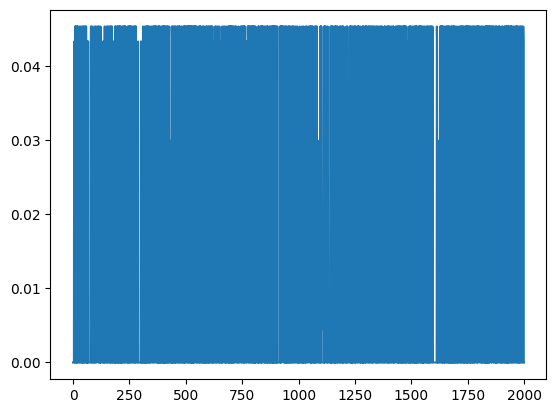

In [127]:
plt.plot(l)
plt.show()

In [459]:
logits.grad = None
softmax_output = F.softmax(logits,dim=1)
loss = softmax_output.sum()
loss.backward()
logits.grad,logits

(tensor([[-7.0699e-08, -2.3625e-09, -2.9372e-09, -7.0599e-09, -3.6151e-08]]),
 tensor([[3.8411, 0.4424, 0.6602, 1.5371, 3.1704]], requires_grad=True))

In [466]:
torch.ones(1,5) @ (softmax_output * (torch.eye(5) - softmax_output.T))

tensor([[-5.9605e-08, -2.3283e-09, -1.8626e-09, -9.3132e-09, -4.4703e-08]],
       grad_fn=<MmBackward0>)